In [1]:
import re
import html
import pandas as pd
import spacy
from string import punctuation
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

### Read in New York Times Dataset
A pre-processed version of the NYT news dataset is read in as a DataFrame.

In [2]:
data_path = "../data/nytimes.tsv"

df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['date', 'headline', 'content'])
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.head()

,date,headline,content
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...


#### Subset the dataframe for testing
For now we work on a subset of the full data (2000 items) to speed up testing on the topic modelling approach.

In [3]:
df1 = df.iloc[:2000, :]

#### Include some extra words to remove from article text
Some unnecessary worsd show up in the article text that also need to be added to the default stopword list.

In [4]:
extra_words = ['-pron-', 'mr.', 'mrs.',
               'ms.', 'mr', 'mrs', 'ms']
removed_words = set(punctuation).union(set(extra_words))

#### Define TextProcessor class
In this class we define methods to clean up the text content for the topic model. Stopword removal and lemmatization are done as well.

In [5]:
class TextPreprocessor:
    def __init__(self):
        sentencizer = spacy.blank('en')
        sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
        self.sentencizer = sentencizer    
        # Compile Regex patterns
        self.email_and_handle_pattern = re.compile(r'(\S*@\S*)')
        self.domain_pattern = re.compile(r'(\S*\.\S*)')
        self.hashtag_pattern = re.compile(r'#[a-zA-Z0-9_]{1,50}')
    
    def clean_patterns(self, text):
        """Cleanup email addresses, handles and hashtags
           This is to avoid polluting the topic model with unnecessary online artefacts.
        """
        text = self.email_and_handle_pattern.sub('', text)
        text = self.domain_pattern.sub('', text)
        text = self.hashtag_pattern.sub('', text)
        return text
    
    def cleanup(self, text):
        """Text cleaning function inspired by the cleanup utility function in fastai.text.transform:
        https://github.com/fastai/fastai/blob/2c5eb1e219f55773330d6aa1649f3841e39603ff/fastai/text/transform.py#L58
        """
        re1 = re.compile(r'  +')
        text = text.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
              'nbsp;', ' ').replace('#36;', '$').replace('\\n', " ").replace('\n', " ").replace(
              'quot;', "'").replace('<br />', "\n").replace('\\"', '"').replace('\\xa0', ' ').replace(
              ' @.@ ', '.').replace('\xa0', ' ').replace(' @-@ ', '-').replace('\\', ' \\ ').replace(
              '“', '').replace('”', '').replace('’', '').replace('•', '').replace('—', '')
        return re1.sub(' ', html.unescape(text))
        
    def tokenize(self, text):
        "Tokenize input string using a spaCy pipeline"
        doc = self.sentencizer(text)
        tokenized_text = ' '.join(token.text for token in doc)
        return tokenized_text

    def lemmatize(self, text):
        "Lemmatize text using a spaCy pipeline"
        stopwords = self.sentencizer.Defaults.stop_words
        combined_stopwords = stopwords.union(removed_words)
        text = self.clean_patterns(text)
        text = self.cleanup(text)
        doc = self.sentencizer(text)
        lemmas = [str(tok.lemma_).lower() for tok in doc
                  if tok.text.lower() not in combined_stopwords]
        return lemmas

### Preproccess text before running topic model

In [6]:
# pip install tqdm
from tqdm import tqdm
tqdm.pandas()

preproc = TextPreprocessor()
df1['lemmas'] = df1['content'].progress_apply(preproc.lemmatize)

100%|██████████| 2000/2000 [00:17<00:00, 115.35it/s]
/home/pprao/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df1.head()

,date,headline,content,lemmas
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...,"[stellar, pitch, keep, mets, afloat, half, sea..."
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,"[mayor, bill, de, blasios, counsel, chief, leg..."
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,"[early, morning, hour, labor, day, year, group..."
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...,"[apple, store, new, york, city, thing, apple, ..."
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...,"[united, states, olympic, swim, trial, spectac..."


### Build LDA Model

In [8]:
def run_lda(text_df, n_topics=9):
    id2word = corpora.Dictionary(text_df['lemmas'])
    corpus = [id2word.doc2bow(text) for text in text_df['lemmas']]
    num_topics = n_topics
    # LDA Model
    lda_model = LdaModel(
       corpus=corpus,
       id2word=id2word,
       num_topics=num_topics, 
       random_state=100,
       chunksize=10,
       passes=5,
       iterations=50,
    )
    return lda_model.show_topics(formatted=False)

### Plot wordclouds of most likely words in each topic

In [9]:
def plot_wordclouds(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      max_words=15,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True);

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud);
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16));
        plt.gca().axis('off');

    plt.subplots_adjust(wspace=0, hspace=0);
    plt.axis('off');
    plt.margins(x=0, y=0);
    plt.tight_layout();

### Run topic model and plot wordclouds

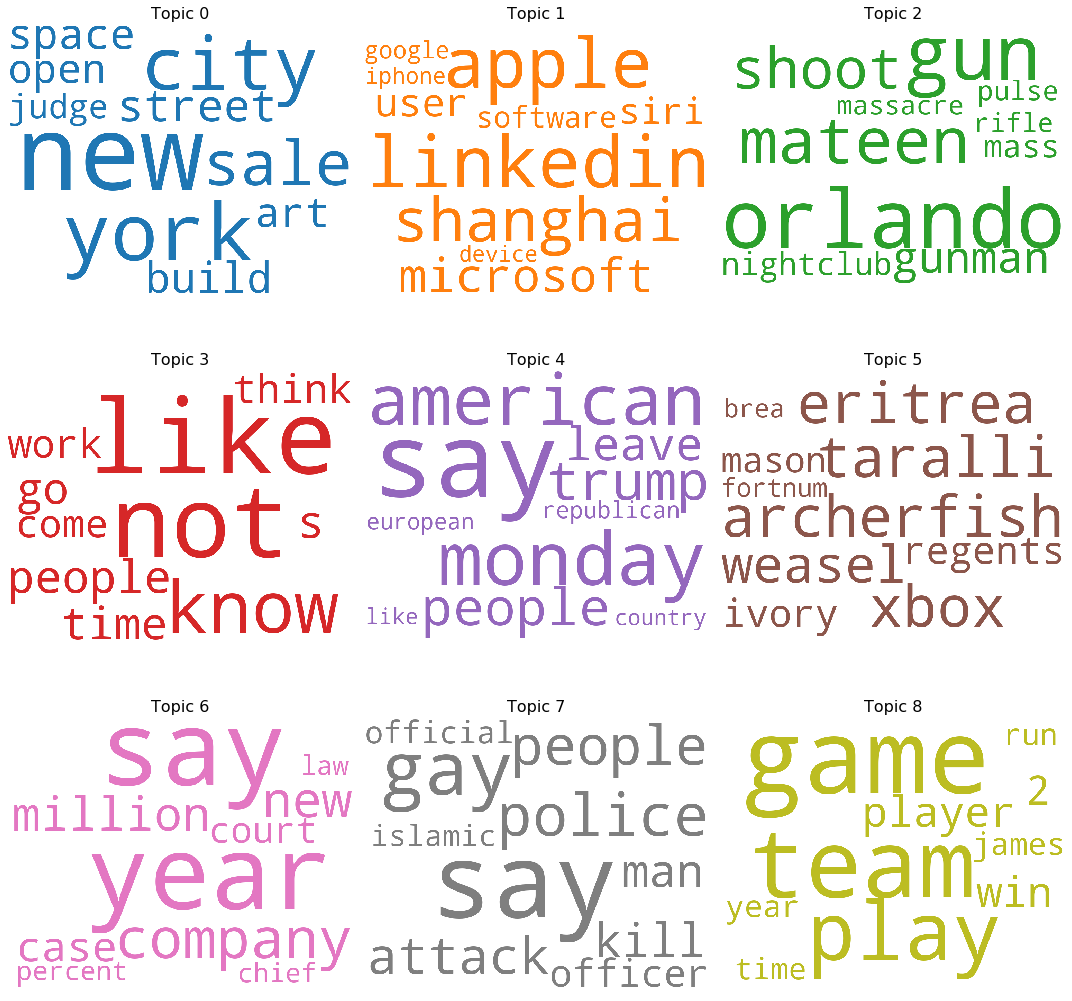

In [10]:
topics = run_lda(df1, n_topics=9)
plot_wordclouds(topics)